<a href="https://colab.research.google.com/gist/ramayer/c30c2b623480bc7e129dee6a1e1181e1/7-compare_stft_implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare STFT implementations from various libraries

## Confirm that if passed the right parameters they can produce the same results.

This notebook tests:

* librosa
* torchaudio
* ssqueezepy

All 3 implement the same algorithm, but have different default parameters.
This notebook shows that if you manually set

* n_fft
* window_lenght
* hop_length
* pad_mode
* center
* window

you will get the same answers (to within floating-point rounding errors), like `-79.561066` vs `-79.561060`)

In [ ]:
%pip install --quiet ssqueezepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 3.7 MB/s eta 0:00:00


## Get a publically accessible elephant rumble, so I don't need to fight Google Drive.

In [ ]:
import requests
import soundfile as sf

elephant_rumble = 'https://www.elephantlisteningproject.org/wp-content/uploads/2017/09/joboPulse.mp3'
headers = {
  "referrer": "https://www.elephantlisteningproject.org/infrasound/",
  "referrerPolicy": "strict-origin-when-cross-origin",
  'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36',
  "sec-ch-ua": "\"Not-A.Brand\";v=\"99\", \"Chromium\";v=\"124\"",
  "sec-ch-ua-mobile": "?0",
  "sec-ch-ua-platform": "\"Linux\""
}
path = elephant_rumble
compressed_audio = requests.get(path,headers=headers).content
y,sr = sf.read(io.BytesIO(compressed_audio),sr=None)


## Create a wrapper class around various STFT algorithms that can configure them equivalently

In [ ]:
import os
import numpy as np
import torch
import torchaudio
import torchaudio.functional as taf
import torchaudio.transforms as tat
import librosa
import ssqueezepy

torch.cuda.is_available()

os.environ['SSQ_PARALLEL'] = '1'
os.environ['SSQ_GPU'] = '0'
device = 'cpu' # 'cuda'

class CompareSTFTs:
  """
      https://pytorch.org/audio/0.10.0/tutorials/audio_feature_extractions_tutorial.html
  """
  def __init__(self,n_fft,win_length,hop_length,device=device):
    self.n_fft = n_fft
    self.win_length = win_length
    self.hop_length = hop_length
    self.torchaudio_spectrogram = tat.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        pad_mode="reflect",
        power=2.0,
    ).to(device)

  def stft_librosa(self,audio):
    cx = librosa.stft(
        audio,
        n_fft=self.n_fft,
        win_length=self.win_length,
        hop_length=self.hop_length,
        window='hann',
        center=True,
        pad_mode='reflect'
    )
    db = librosa.amplitude_to_db(np.abs(cx),ref=np.max)
    return db

  def stft_torchaudio(self,audio):
    pwr = self.torchaudio_spectrogram(audio)
    db = librosa.power_to_db(pwr.cpu(),ref=np.max)
    return db

  def stft_ssqueeze(self,audio):
    """
      Note ssqueezepy has a different default filter.
      https://github.com/OverLordGoldDragon/ssqueezepy/blob/master/ssqueezepy/_stft.py#L24
    """
    cx = ssqueezepy.stft(
        audio,
        n_fft=self.n_fft,
        win_len=self.win_length,
        hop_len=self.hop_length,
        window='hann'
    )
    db = librosa.amplitude_to_db(np.abs(cx),ref=np.max)
    return db



## Verify that they all return the same numbers numerically (within floating point math rounding errors)

In [ ]:
y,sr = librosa.load(io.BytesIO(compressed_audio),sr=1000)
rstft = CompareSTFTs(1024,1024,1024//4)

s1 = rstft.stft_librosa(y)
s2 = rstft.stft_torchaudio(torch.tensor(y).to(device))
s3 = rstft.stft_ssqueeze(y)

(s1.shape,s2.shape,s3.shape,s1[0:3,0:3],s2[0:3,0:3],s3[0:3,0:3])


((513, 55),
 (513, 55),
 (513, 55),
 array([[-37.41708 , -43.51995 , -79.56106 ],
        [-37.27341 , -43.341995, -80.      ],
        [-36.949253, -42.973648, -80.      ]], dtype=float32),
 array([[-37.41708 , -43.51995 , -79.561066],
        [-37.27341 , -43.341995, -80.      ],
        [-36.949253, -42.973648, -80.      ]], dtype=float32),
 array([[-37.41708 , -43.51995 , -79.56108 ],
        [-37.27341 , -43.341995, -80.      ],
        [-36.949253, -42.973648, -80.      ]], dtype=float32))

In [ ]:
# verify that they all make the same pictures

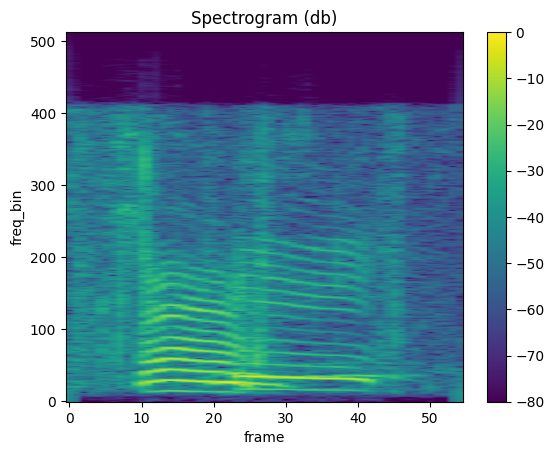

<Figure size 1000x600 with 0 Axes>

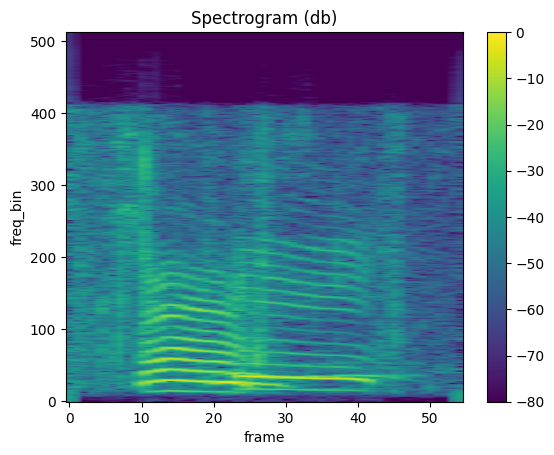

<Figure size 1000x600 with 0 Axes>

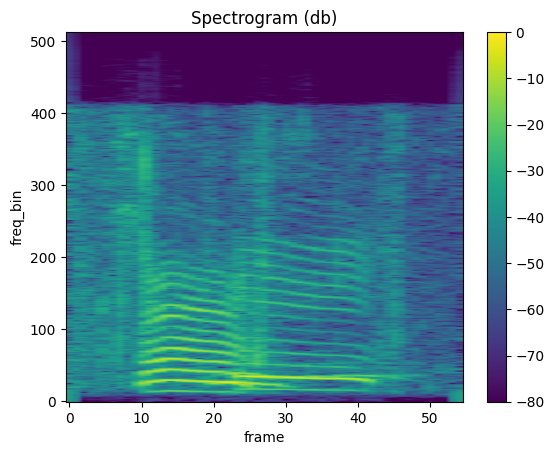

<Figure size 1000x600 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
def plot_db(spec_in_db, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    plt.figure(figsize=(10, 6))

    im = axs.imshow(spec_in_db, origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
plot_db(s1)
plot_db(s2)
plot_db(s3)